# Assignment 4

Approximate time needed: 6-7 hours

**Team Name**: Heisenberg

**Team Members/Rollnumbers**: Laksh Nanwani-2021701002, Arpit Sahni-2021702009, Haasith Pasala-2021702017


    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

The third part of this assignment will require you to use camera intrinsics to estimate the bounding box of a car.

---
### 4.1 Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
import os
import math

In [5]:
%matplotlib tk
image_points = []
fig = plt.figure(figsize=(20,30))

img = mpimg.imread('q1/dlt1.jpeg')

def onclick(event):
    
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

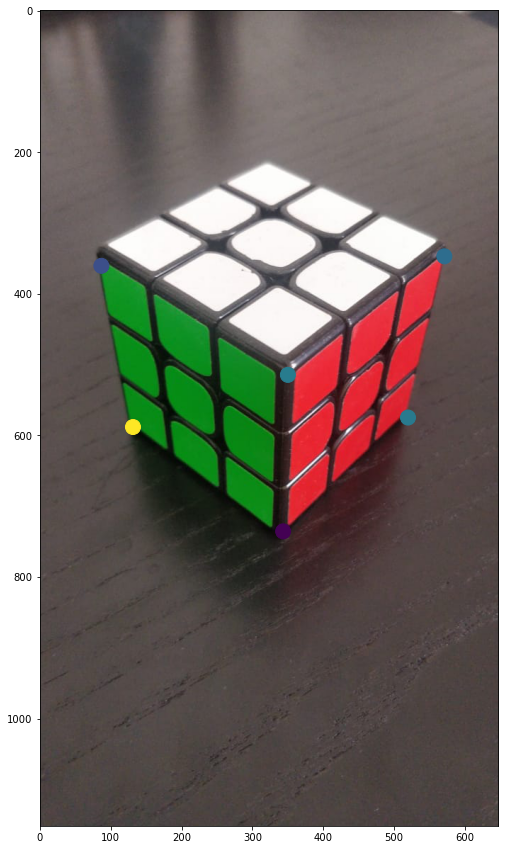

In [6]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('q1/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [7]:
x = np.asarray(image_points)
x

array([[350.12841636, 514.42769917],
       [571.19451444, 346.95338244],
       [343.42944369, 735.49379725],
       [ 86.63549137, 360.35132778],
       [131.29530917, 588.11639853],
       [519.83572398, 574.71845319]])

In [2]:
# imgpoints = np.asarray([[352.36140725, 505.49573561],
#        [575.66049622, 335.78842799],
#        [341.1964528 , 737.72678814],
#        [ 91.10147315, 346.95338244],
#        [323.33252568, 217.43991084],
#        [225.08092654, 268.7987013 ]])

######### 0.06 error ###########
x = np.asarray([[354.5943981391745, 507.72872649738315],
[575.6604962201977, 338.02141887962784],
[343.42944369063775, 733.2608063578213],
[93.3344640434193, 349.18637332816434],
[135.76129094785824, 590.3493894165535],
[522.0687148672225, 572.4854622988951]])
#####################################
# 352.9348126915095 501.8845013343878
# 573.8382425620243 349.30171987743415
# 348.380102797272 729.6199960462588
# 93.3163487199763 356.13378471879025
# 136.58609271523187 588.4239893248988
# 523.7364337254128 572.4825046950679
#####################################
# x = np.asarray([[350.12841635975974, 509.9617173870905],
# [575.6604962201977, 338.02141887962784],
# [343.42944369063775, 733.2608063578213],
# [88.8684822640048, 346.95338243845697],
# [327.79850746268676, 217.43991083543324],
# [227.31391742585788, 262.09972862957943]])
x

array([[354.59439814, 507.7287265 ],
       [575.66049622, 338.02141888],
       [343.42944369, 733.26080636],
       [ 93.33446404, 349.18637333],
       [135.76129095, 590.34938942],
       [522.06871487, 572.4854623 ]])

In [3]:
X = np.asarray(
      [[0,0,0],
       [4,0,0],
       [0,4,0],
       [0,0,4],
       [0,4,4],
       [4,4,0]])


Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [4]:
def get_M(x, X):
    Np = x.shape[0]
    M=[]
    for i in range(Np):
        xt,yt = x[i,0],x[i,1]
#         print(xt,yt)
        Xt,Yt,Zt = X[i,0],X[i,1],X[i,2]
        M.append([-Xt,-Yt,-Zt,-1,0,0,0,0,xt*Xt,xt*Yt,xt*Zt,xt])
        M.append([0,0,0,0,-Xt,-Yt,-Zt,-1,yt*Xt,yt*Yt,yt*Zt,yt])
    return np.asarray(M) 
def get_P_DLT(x, X):
    M = get_M(x,X)
    U,D,Vt = np.linalg.svd(M, full_matrices=False)
    p = Vt[-1,:]/Vt[-1,-1]
    P = p.reshape(3,4)
    return P

In [9]:
P = get_P_DLT(x,X)
P

array([[ 7.74220604e+01,  2.12594617e+01, -6.29973444e+01,
         3.54752672e+02],
       [-2.93881935e+01,  1.07898820e+02, -3.07510010e+01,
         5.07736983e+02],
       [ 3.85945415e-02,  7.02613624e-02,  2.54408797e-02,
         1.00000000e+00]])

## Theory




#### Explain how DLT is implemented and show why it works (proof)

The steps involved in DLT are as follows:</br>
(a) Build the matrix M for the system</br>
&emsp;&emsp;&emsp;&emsp;$M = \left[ \begin{array}{c}
             \mathbf{a_{x_1}^T}\\
             \mathbf{a_{y_1}^T}\\
             \vdots \\
             \mathbf{a_{x_I}^T}\\
             \mathbf{a_{y_I}^T}\\
            \end{array}\right]$</br>
&emsp;&emsp;&emsp;&emsp;$ Mp=0 $            
&emsp;&emsp;Where,</br>
&emsp;&emsp;&emsp;&emsp;I is number of points taken.</br>
&emsp;&emsp;&emsp;&emsp; $\mathbf{a_{x_i}^T} = (-X_i,-Y_i,-Z_i,-1,0,0,0,0,x_iX_i,x_iY_i,x_iZ_i)$</br>
&emsp;&emsp;&emsp;&emsp; $\mathbf{a_{y_i}^T} = (0,0,0,0,-X_i,-Y_i,-Z_i,-1,y_iX_i,y_iY_i,y_iZ_i)$ </br>
   
   (b) Now solve $ SVD(M) = UDV^T $ </br>
&emsp;&emsp; We get the 1D matrix p from the last row of V^T  </br>
&emsp;&emsp;&emsp;&emsp; $ p=v_{12} $</br>
&emsp;&emsp;&emsp;&emsp; $ P = \left[ \begin{array}{cccc}
             p_1 & p_2 & p_3 & p_4\\
             p_5 & p_6 & p_7 & p_8\\
             p_9 & p_{10} & p_{11} & p_{12}\\
            \end{array}\right]$</br>
</br>
</br>
</br>
##### Proof :
For an uncalibrated camera, we require at least 6 points to find the transformation matrix having 11 unknowns.</br>

P -> 11 Unknowns - (6 extrinsic and 5 Intrinsic parameters). </br>
The image cordinates are obtained from the world coordinates by,</br>

&emsp;&emsp;&emsp;&emsp; $ x_{image-coordinates} = P_{3x4}X_{world-coordinates} $</br>
&emsp;&emsp;&emsp;&emsp; $ x_i = P_{3x4} X_i =   \left[ \begin{array}{cccc}
             p_1 & p_2 & p_3 & p_4\\
             p_5 & p_6 & p_7 & p_8\\
             p_9 & p_{10} & p_{11} & p_{12}\\
            \end{array}\right]X_i$</br>
            
&emsp;&emsp;Let,</br>
&emsp;&emsp;&emsp;&emsp;$P_1 = \left[ \begin{array}{c}
             p_{11}\\
             p_{12}\\
             p_{13}\\
             p_{14}\\
            \end{array}\right] P_2  = \left[ \begin{array}{c}
             p_{21}\\
             p_{22}\\
             p_{23}\\
             p_{24}\\
            \end{array}\right]P_3 = \left[ \begin{array}{c}
             p_{31}\\
             p_{32}\\
             p_{33}\\
             p_{34}\\
            \end{array}\right]$ </br></br>
            
&emsp;&emsp;&emsp;&emsp; $ x_i = P_{3x4} X_i = \left[ \begin{array}{c}
             P_1^T\\
             P_2^T\\
             P_3^T\\   
             \end{array}\right] X_i$ </br></br>
             
&emsp;&emsp;&emsp;&emsp; $ 
             \left[ \begin{array}{c}
             u_i\\
             v_i\\
             w_i\\   
             \end{array}\right]   =
             x_i = P_{3x4} X_i = \left[ \begin{array}{c}
             P_1^T\\
             P_2^T\\
             P_3^T\\   
             \end{array}\right] X_i
             =\left[ \begin{array}{c}
             P_1^T X_i\\
             P_2^T X_i\\
             P_3^T X_i\\   
             \end{array}\right]$ </br>
             
&emsp;&emsp; &emsp;&emsp; But, $x_i = \left[ \begin{array}{c}
             x_i\\
             y_i\\
             1\\   
             \end{array}\right] $ </br></br>
             
&emsp;&emsp; Therefore, $ \left[ \begin{array}{c}
             x_i\\
             y_i\\
             1\\   
             \end{array}\right]
             =\left[ \begin{array}{c}
             u_i\\
             v_i\\
             w_i\\   
             \end{array}\right]
             =\left[ \begin{array}{c}
             P_1^T X_i\\
             P_2^T X_i\\
             P_3^T X_i\\   
             \end{array}\right]$ </br>
             
&emsp;&emsp;&emsp;&emsp; $ x_i = \frac{u_i}{w_i} = \frac{P_1^TX_i}{P_3^TX_i} $ &emsp;&emsp; $ y_i = \frac{v_i}{w_i} = \frac{P_2^TX_i}{P_3^TX_i} $ </br>       

&emsp;&emsp; Now, rearranging these equations : </br>
&emsp;&emsp;&emsp;&emsp; $ x_iP_3^TX_i - P_1^TX_i = 0 $ </br>
&emsp;&emsp;&emsp;&emsp; $ y_iP_3^TX_i - P_2^TX_i = 0 $ </br>

&emsp;&emsp; Rewrite the above two equations as </br>
&emsp;&emsp;&emsp;&emsp;&emsp; $ a_{x_i}^Tp = 0 $</br>
&emsp;&emsp;&emsp;&emsp;&emsp; $ a_{y_i}^Tp = 0 $</br>
&emsp;&emsp; Where, </br>
&emsp;&emsp;&emsp;&emsp;&emsp; $ p= p_k =\left[ \begin{array}{c}
             P_1 \\
             P_2 \\
             P_3 \\   
             \end{array}\right] = vec(P^T) $</br>
             
&emsp;&emsp;&emsp;&emsp;&emsp;$ a_{x_i}^Tp = [-X_i^T,0^T,x_iX_i^T] = [-X_i,-Y_i,-Z_i,-1,0,0,0,0,x_iX_i,x_iY_i,x_iZ_i] $</br>

&emsp;&emsp;&emsp;&emsp;&emsp;$ a_{y_i}^Tp = [0^T,-X_i^T,y_iX_i^T] = [0,0,0,0,-X_i,-Y_i,-Z_i,-1,x_iX_i,x_iY_i,x_iZ_i] $</br>

&emsp;&emsp;Stacking all together, </br>

&emsp;&emsp;&emsp;&emsp;&emsp;$\left[ \begin{array}{c}
             \mathbf{a_{x_1}^T}\\
             \mathbf{a_{y_1}^T}\\
             \vdots \\
             \mathbf{a_{x_I}^T}\\
             \mathbf{a_{y_I}^T}\\
            \end{array}\right]p = M_{2Ix12}p_{12x1} = 0$</br>
            
&emsp;&emsp;The above is a system of linear equation in the for $ Ax=0 $. Solving them is equivalent to the null space of A. </br>
&emsp;&emsp;So, we apply SVD to solve $ Mp=0 $ choosing p as the singular vector belonging to the singular value of 0 </br>
&emsp;&emsp;In case of redundant observations, we will have contradictions( $ Mp \neq 0 $)</br>
&emsp;&emsp;&emsp;&emsp; Mp = w</br>

&emsp;&emsp; Now, we need to find p such that it minimizes</br>
&emsp;&emsp;&emsp;&emsp;$ \Omega = w^Tw $</br>
&emsp;&emsp;&emsp;&emsp;$ \hat{p} = argmin_p w^Tw $</br>

&emsp;&emsp;$ M_{2Ix12} = U_{2Ix12}S_{12x12}V^T_{12x12}$</br>
&emsp;&emsp;Choosing $ p = v_{12} $ (the singular vector belonging to the smallest singular value $ S_{12}$) minimizes $ \Omega $</br>
&emsp;&emsp;Reshaping the $p$ vector gives the transformation vector $ P $</br>
&emsp;&emsp;&emsp;&emsp;$P=   \left[ \begin{array}{cccc}
             p_1 & p_2 & p_3 & p_4\\
             p_5 & p_6 & p_7 & p_8\\
             p_9 & p_{10} & p_{11} & p_{12}\\
            \end{array}\right]$</br>



#### When does DLT fail?

DLT fails when we take all the points approximately in the same plane. This leads to rank deficiency in M matrix. So this is generally avoided.

## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [10]:
#Get reprojected points
def get_points(P, X):
    xi=[]
    for Xi in X:
        Xi = np.append(Xi,1)
        x = np.dot(P,Xi)
        x = x/x[-1]
        xi = np.append(xi,x)
    return xi.reshape(len(X),3)[:,:2]     

#Get reprojection error
def get_err(x, X, P):
    x_out = get_points(P,X)
    MSE = np.square(x-x_out).mean()
    err = np.sqrt(MSE)
    return err

In [11]:
xy = get_points(P,X)
xy

array([[354.75267174, 507.73698269],
       [575.58340326, 338.00380174],
       [343.30594498, 733.25443834],
       [ 93.27164353, 349.19742035],
       [135.81134152, 590.34058657],
       [522.13071613, 572.49962917]])

In [12]:
get_err(x,X,P)

0.06913798267687411

In [13]:
print("Reprojection Error is:", get_err(x, X, P))

Reprojection Error is: 0.06913798267687411


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [14]:
def ret_RKT(P):
    H = P[:3,:3]
    h = P[:,3]
    H_inv = np.linalg.inv(H)
    T = -np.dot(H_inv,h)
    Q,R1 = np.linalg.qr(H_inv)
    K = np.linalg.inv(R1)
    R = Q.T
    return R,K,T

R, K, T = ret_RKT(P)
P_out = np.dot(K, np.dot(R, np.c_[(np.identity(3), -T)]))
P_out,P

(array([[ 7.74220604e+01,  2.12594617e+01, -6.29973444e+01,
          3.54752672e+02],
        [-2.93881935e+01,  1.07898820e+02, -3.07510010e+01,
          5.07736983e+02],
        [ 3.85945415e-02,  7.02613624e-02,  2.54408797e-02,
          1.00000000e+00]]),
 array([[ 7.74220604e+01,  2.12594617e+01, -6.29973444e+01,
          3.54752672e+02],
        [-2.93881935e+01,  1.07898820e+02, -3.07510010e+01,
          5.07736983e+02],
        [ 3.85945415e-02,  7.02613624e-02,  2.54408797e-02,
          1.00000000e+00]]))

#### Verifying the R, K, T Values

Use `np.isclose` to verify the matrix

In [15]:
np.isclose(P_out,P)

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

**Reproject the world points with P matrix you have obtained via DLT and visualize**

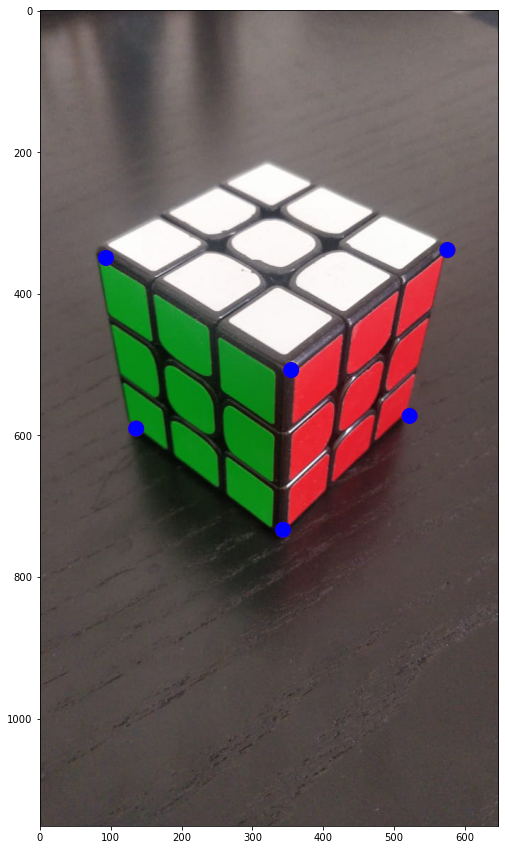

In [16]:
N = len(x)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('q1/dlt1.jpeg')
imgplot = plt.imshow(img)

red = ['r']*N
blue = ['b']*N
area = (15 * np.ones(N))**2 

plt.scatter(x[:,0], x[:,1], c=red, s=area)
plt.scatter(xy[:,0], xy[:,1], c=blue, s=area)
plt.show()

### Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in `q1/zhangs` folder for this task. Familiarize yourself with the different parameters for this method.

**Reference**: https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html

In [17]:
import cv2
import os

In [18]:
chessboard_images = []
path = "q1/Zhangs/"
for img_name in os.listdir(path):
    chessboard_images.append(mpimg.imread(os.path.join(path, img_name)))

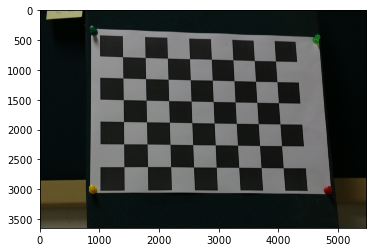

In [19]:
imgplot = plt.imshow(chessboard_images[12])

In [20]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:8].T.reshape(-1,2)

objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for img in chessboard_images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (6,8), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (6,8), corners, ret)
        cv2.namedWindow('img', cv2.WINDOW_NORMAL)
        cv2.imshow('img', img)
        cv2.resizeWindow('img', 1500, 1500)
        cv2.waitKey(500)

cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x563fe89e7310) is not the object's thread (0x563fe8a49d40).
Cannot move to target thread (0x563fe89e7310)

QObject::moveToThread: Current thread (0x563fe89e7310) is not the object's thread (0x563fe8a49d40).
Cannot move to target thread (0x563fe89e7310)

QObject::moveToThread: Current thread (0x563fe89e7310) is not the object's thread (0x563fe8a49d40).
Cannot move to target thread (0x563fe89e7310)

QObject::moveToThread: Current thread (0x563fe89e7310) is not the object's thread (0x563fe8a49d40).
Cannot move to target thread (0x563fe89e7310)

QObject::moveToThread: Current thread (0x563fe89e7310) is not the object's thread (0x563fe8a49d40).
Cannot move to target thread (0x563fe89e7310)

QObject::moveToThread: Current thread (0x563fe89e7310) is not the object's thread (0x563fe8a49d40).
Cannot move to target thread (0x563fe89e7310)

QObject::moveToThread: Current thread (0x563fe89e7310) is not the object's thread (0x563fe8a49d40).
Cannot move to tar

In [21]:
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

---
### 4.2 Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. You should first estimate the fundamental matrix from these two images.

<img src="./q2/img1.jpg" alt="image 1" width="400"/>
<img src="./q2/img2.jpg" alt="image 2" width="400"/>


Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image. For this question you will need to compute the F matrix on your own without using inbuilt functions. 

In [31]:
%matplotlib tk
image_points1 = []
fig = plt.figure(figsize=(20,30))

img1 = mpimg.imread('q2/img1.jpg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points1.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img1)
plt.show()

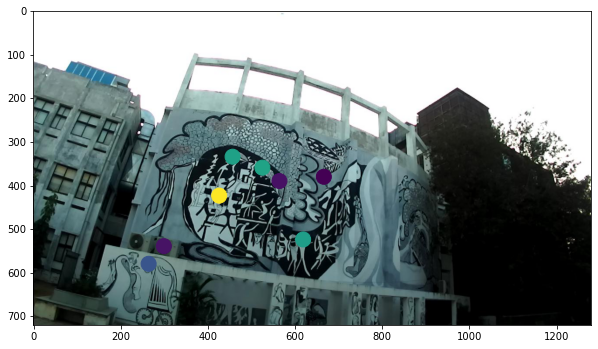

In [32]:
%matplotlib inline
N = len(image_points1)
image_points1 = np.array(image_points1)
fig = plt.figure(figsize=(10,15))

img1=mpimg.imread('q2/img1.jpg')
imgplot = plt.imshow(img1)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points1[:,0], image_points1[:,1], c=colors, s=area)
plt.show()

In [35]:
%matplotlib tk
image_points2 = []
fig = plt.figure(figsize=(20,30))

img2 = mpimg.imread('q2/img2.jpg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points2.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img2)
plt.show()

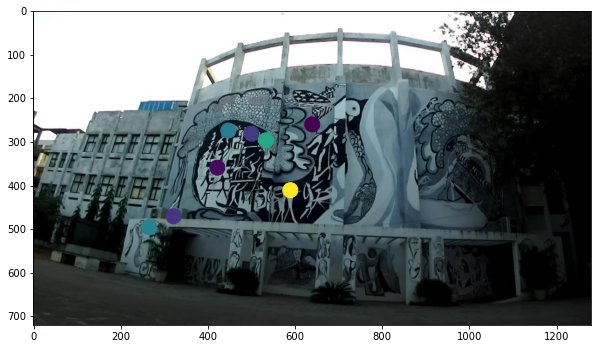

In [36]:
%matplotlib inline
N = len(image_points2)
image_points2 = np.array(image_points2)
fig = plt.figure(figsize=(10,15))

img2=mpimg.imread('q2/img2.jpg')
imgplot = plt.imshow(img2)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points2[:,0], image_points2[:,1], c=colors, s=area)
plt.show()

In [37]:
xp1 = np.asarray(image_points1)
xp2 = np.asarray(image_points2)
xp1,xp2

(array([[425.86557472, 423.21002132],
        [456.56919946, 333.89038573],
        [524.95454545, 359.01153324],
        [564.03188602, 389.71515798],
        [665.91209537, 379.94582283],
        [618.46103896, 523.69461136],
        [298.86421787, 539.04642373],
        [263.97373522, 579.5193836 ]]),
 array([[421.67871681, 359.01153324],
        [446.79986431, 273.87875557],
        [499.83339795, 280.8568521 ],
        [533.32826129, 296.20866447],
        [639.39532855, 259.92256251],
        [589.15303353, 410.64944757],
        [321.19412677, 470.66107773],
        [265.36935453, 495.78222524]]))

In [22]:
xp1 = np.asarray([[425.86557472, 423.21002132],
        [456.56919946, 333.89038573],
        [524.95454545, 359.01153324],
        [564.03188602, 389.71515798],
        [665.91209537, 379.94582283],
        [618.46103896, 523.69461136],
        [298.86421787, 539.04642373],
        [263.97373522, 579.5193836 ]])

xp2 = np.asarray([[421.67871681, 359.01153324],
        [446.79986431, 273.87875557],
        [499.83339795, 280.8568521 ],
        [533.32826129, 296.20866447],
        [639.39532855, 259.92256251],
        [589.15303353, 410.64944757],
        [321.19412677, 470.66107773],
        [265.36935453, 495.78222524]])
# xp1 = np.asarray([[397.9531886 , 265.50503974],
#         [504.02025586, 259.92256251],
#         [665.91209537, 379.94582283],
#         [618.46103896, 526.48584997],
#         [300.25983718, 543.23328164],
#         [263.97373522, 585.10186083],
#         [254.20440008, 703.72950184],
#         [304.4466951 , 714.89445629]])
# xp2 = np.asarray([[402.14004652, 233.4057957 ],
#         [480.29472766, 198.51531305],
#         [639.39532855, 258.52694321],
#         [590.54865284, 410.64944757],
#         [323.98536538, 469.26545842],
#         [266.76497383, 497.17784454],
#         [254.20440008, 594.87119597],
#         [276.53430897, 600.45367319]])

In [23]:
x1 = np.c_[ xp1, np.ones(xp1.shape[0]) ]
x2 = np.c_[ xp2, np.ones(xp2.shape[0]) ]

In [24]:
def get_fundamental_matrix(x1,x2):
    A = []
    for x1t,x2t in zip(x1,x2):
        A.append([x1t[0]*x2t[0],x1t[1]*x2t[0],x2t[0],
                  x1t[0]*x2t[1],x1t[1]*x2t[1],x2t[1],
                  x1t[0],x1t[1],1])
    U,D,Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3,3)
    return F
def get_error(x1,x2,F):
    err = []
    for i in range(len(x1)):
        err.append(np.dot(np.dot(x2[i],F),x1[i].T))
    return err


In [25]:
def get_norm_f_matrix(x1,x2):
    mean1 = np.mean(x1[:2],axis=0)
    mean2 = np.mean(x2[:2],axis=0)
    std1 = np.sqrt(2)/np.std(x1[:2])
    std2 = np.sqrt(2)/np.std(x2[:2])
    T1 = np.asarray([[std1,0,-std1*mean1[0]],[0,std1,-std1*mean1[1]],[0,0,1]])
    T2 = np.asarray([[std2,0,-std2*mean2[0]],[0,std2,-std2*mean2[1]],[0,0,1]])
    x1_n = np.dot(T1,x1.T).T
    x2_n = np.dot(T2,x2.T).T
    F_n = get_fundamental_matrix(x1_n,x2_n)
    U,D,Vt = np.linalg.svd(F_n)
    D = np.diag(D)
    D[2,2]=0
    F_temp = np.dot(np.dot(U,D),Vt)
    F = np.dot(np.dot(T2.T,F_temp),T1)
    return F


In [26]:
F_norm = get_norm_f_matrix(x1,x2)
error = get_error(x1,x2,F_norm)
print(error)

[-0.00215680400550311, -0.00010487068290743196, -0.0011110833180070223, -0.0029039485089565886, -0.004687912233090508, -0.017104022987601164, -0.005213792034741482, -0.005837660066851935]


<a id='lines'></a>

In [27]:
lines1 = np.dot(F_norm,x1.T).T
lines2 = np.dot(x2,F_norm)
lines2,lines1

(array([[-3.32404271e-03,  2.47995971e-03,  3.63894752e-01],
        [-4.43222832e-03,  2.03241773e-03,  1.34490932e+00],
        [-4.44225264e-03,  1.23982961e-03,  1.88575651e+00],
        [-4.31202885e-03,  7.48170986e-04,  2.13764424e+00],
        [-4.95894716e-03, -8.77968858e-04,  3.63111558e+00],
        [-2.98635859e-03,  1.18481557e-06,  1.82922193e+00],
        [-1.74703985e-03,  4.08351573e-03, -1.68429064e+00],
        [-1.33140549e-03,  4.94428964e-03, -2.51969327e+00]]),
 array([[ 4.12667742e-03, -2.53727593e-03, -8.31377519e-01],
        [ 5.41493507e-03, -2.22701307e-03, -1.80956556e+00],
        [ 4.91160919e-03, -1.35329201e-03, -2.07601606e+00],
        [ 4.37790885e-03, -8.40693407e-04, -2.08874579e+00],
        [ 4.33844583e-03,  4.22493831e-04, -2.88848559e+00],
        [ 2.26156322e-03, -5.23483660e-05, -1.32801403e+00],
        [ 2.61557520e-03, -4.02741932e-03,  1.05022833e+00],
        [ 2.07023811e-03, -4.42974703e-03,  1.64097443e+00]]))

In [28]:
def drawlines(img,lines,pts):
    c = img.shape[1]
    for r,pt in zip(lines,pts):
        color = 255*np.random.rand(3,)
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img = cv2.line(img, (x0,y0), (x1,y1), color ,4)
        center = (int(pt[0]),int(pt[1]))
        img = cv2.circle(img, center, 5, color, 5)
    return img

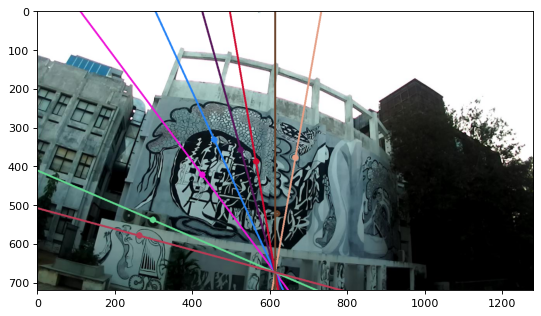

In [29]:
%matplotlib inline
img1 = mpimg.imread('q2/img1.jpg')
image1 = drawlines(img1,lines2,xp1)
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(image1)
plt.show()

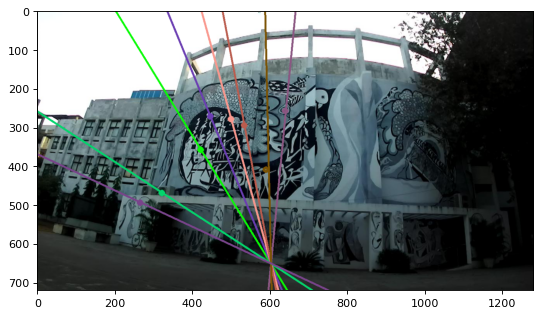

In [30]:
%matplotlib inline
img2 = mpimg.imread('q2/img2.jpg')
image2 = drawlines(img2,lines1,xp2)
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(image2)
plt.show()

In [31]:
U1,D1,Vt1 = np.linalg.svd(F_norm)
epipole1 = Vt1[-1]/Vt1[-1,-1]
U2,D2,Vt2 = np.linalg.svd(F_norm.T)
epipole2 = Vt2[-1]/Vt2[-1,-1]
print("The Epipoles are: \n " + str(epipole1[:2]) +"\n "+ str(epipole2[:2]))

The Epipoles are: 
 [612.79353756 674.6307733 ]
 [602.30084811 651.92901087]


**Provide a clear explanation on your approach for both this task and the next**

The normalized 8-point algorithm is used in here.</br>
Given $n\geq 8 $ correspondences of $x_1 \iff x_2 $, the follow the below steps.</br>

&emsp;&emsp;1) First normalize the given points $x_1 $ and $x_2$ using the similarity matrices $T_1$ and $T_2$ </br>
&emsp;&emsp;&emsp;&emsp;where, </br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$ T_i=\left[ \begin{array}{ccc}
             s_i & 0 & -s_i\bar{u_i} \\
             0 & s_i & -s_i\bar{v_i} \\
             0 & 0 & 1        \\
            \end{array}\right]$</br>
            
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $s_i = \frac{\sqrt{2}}{std(x_i)}$ </br>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\bar{u}$ and $\bar{v}$ are the means of x and y coordinates. </br>

&emsp;&emsp;2) Now, with these point - correspondences, build the matrix A and compute its SVD.</br>
&emsp;&emsp;3) The singular vector corresponding to the smallest singular value will give the $\bar{F}$ </br>
&emsp;&emsp;4) Find the SVD of $\bar{F}$ : $\bar{F}=UDV^T$  </br>
&emsp;&emsp;5) The $\bar{F}$ matrix is made a rank deficient matrix by setting the smallest singular value $D_{33}=0$ and compose the $\hat{F}$ matrix back again by:$\hat{F}=UDV^T$  </br>
&emsp;&emsp;6) Finally, the fundamental matrix $F$ is obtained by denormalizing the $\hat{F}$ matrix with the similarity transforms :  $F = T_2^T\hat{F}T$  </br>


#### Task 2
Report the location of the epipoles. Mathematically find the epipoles and verify that the lines intersect at the epipole.

<a id='epipoles'></a>

In [32]:
U1,D1,Vt1 = np.linalg.svd(F_norm.T)
epipole1 = Vt1[-1]/Vt1[-1,-1]
U2,D2,Vt2 = np.linalg.svd(F_norm)
epipole2 = Vt2[-1]/Vt2[-1,-1]
print("The Epipoles are located at : \n Image-1 :" + str(epipole1[:2]) +"\n Image-2 :"+ str(epipole2[:2]))

The Epipoles are located at : 
 Image-1 :[602.30084811 651.92901087]
 Image-2 :[612.79353756 674.6307733 ]


Lets take two lines from the Image-1,  </br>
[Here](#lines)

In [33]:
m1,c1 = -lines1[0,0]/lines1[0,1],-lines1[0,2]/lines1[0,1]
m2,c2 = -lines1[1,0]/lines1[1,1],-lines1[1,2]/lines1[1,1]
xi = (c2-c1)/(m1-m2)
yi = m1*xi + c1
print("The intersection point is",[xi,yi])

The intersection point is [602.3008481079662, 651.9290108723262]


From the above result, we can observe that the intersection point of two epipolar lines of image1 coincides with the epipole of the Image-1 calculated [above](#epipoles).

</br>
Similarly, if we take two lines from image-2 and find the intersection point. Then it will coincide with the epipole of the Image-2.

In [34]:
m1,c1 = -lines2[0,0]/lines2[0,1],-lines2[0,2]/lines2[0,1]
m2,c2 = -lines2[1,0]/lines2[1,1],-lines2[1,2]/lines2[1,1]
xi = (c2-c1)/(m1-m2)
yi = m1*xi + c1
print("The intersection point is",[xi,yi])

The intersection point is [612.7935375567961, 674.6307732957575]


____
### 4.3 Drawing a bounding box around a car and localizing it in the camera frame
You’ve been provided with an image, also taken from a self-driving car, that shows another car in front. The camera has been placed on top of the car, 1.65 m from the ground, and assume the image plane is perfectly perpendicular to the ground. K is provided to you. Your task is to draw a 3D-bounding box around the car in front as shown. Your approach should be to place eight points in the 3D world such that they surround all the corners of the car, then project them onto the image, and connect the projected image points using lines. You might have to apply a small 5° rotation about the vertical axis to align the box perfectly. Rough dimensions of the car - h: 1.38 m, w: 1.51, l: 4.10. (Hint: Fix a point on the ground as your world origin.). Also estimate the approximate translation vector to the mid-point of the two rear wheels of the car in the camera frame.

![Kitti car](./q3/image.png)

In [96]:
%matplotlib tk
image_points = []
fig = plt.figure(figsize=(20,30))

car_img = mpimg.imread('q3/image.png')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(car_img)
plt.show()

In [97]:
cam_point = np.asarray(image_points)
cam_point

array([[858.57004203, 248.79790299]])

In [35]:
cam_point = np.asarray([833.9330043 , 306.28432438])

In [36]:
X_org = np.asarray([0,0,0,1]).T
cam_org = np.append(cam_point,1).T
K = np.asarray([[7.2153e+02,0,6.0955e+02],[0,7.2153e+02,1.7285e+02],[0,0,1]])
ty = -1.65
t = np.dot(np.linalg.inv(K),cam_org)
T = t/t[1] *ty
T

array([-2.77463808, -1.65      , -8.9221758 ])

In [37]:
a = math.radians(-5)
R = np.asarray([[np.cos(a),0,np.sin(a)],[0,1,0],[-np.sin(a),0,np.cos(a)]])
R

array([[ 0.9961947 ,  0.        , -0.08715574],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.08715574,  0.        ,  0.9961947 ]])

In [38]:
RT = np.c_[R,T]
P = np.dot(K,RT)
bb_world = np.asarray([[0,0,0],
                       [-1.51,0,0],
                       [-1.51,1.38,0],
                       [0,1.38,0],
                       [0,1.38,-4.10],
                       [0,0,-4.10],
                       [-1.51,0,-4.10],
                       [-1.51,1.38,-4.10],
                      ])
BB_world = np.c_[bb_world,np.ones(bb_world.shape[0])]
BB_image = np.dot(P,BB_world.T)
bb_image = BB_image/BB_image[2,:]
bb_image = np.c_[bb_image[0,:].T,bb_image[1,:].T]
bb_image[:,1]

array([306.28432438, 304.34473172, 194.36731974, 194.68470763,
       187.82804872, 264.38251996, 263.46563849, 187.67801357])

In [41]:
%matplotlib tk
car_img = mpimg.imread('q3/image.png')
plt.imshow(car_img)
plt.scatter(bb_image[:,0],bb_image[:,1],color='green', marker='s')
plt.plot([bb_image[0,0],bb_image[1,0]],[bb_image[0,1],bb_image[1,1]],color='green',linewidth=2.5)
plt.plot([bb_image[0,0],bb_image[3,0]],[bb_image[0,1],bb_image[3,1]],color='green',linewidth=2.5)
plt.plot([bb_image[0,0],bb_image[5,0]],[bb_image[0,1],bb_image[5,1]],color='green',linewidth=2.5)
plt.plot([bb_image[3,0],bb_image[4,0]],[bb_image[3,1],bb_image[4,1]],color='green',linewidth=2.5)
plt.plot([bb_image[3,0],bb_image[2,0]],[bb_image[3,1],bb_image[2,1]],color='green',linewidth=2.5)
plt.plot([bb_image[1,0],bb_image[2,0]],[bb_image[1,1],bb_image[2,1]],color='green',linewidth=2.5)
plt.plot([bb_image[4,0],bb_image[7,0]],[bb_image[4,1],bb_image[7,1]],color='green',linewidth=2.5)
plt.plot([bb_image[7,0],bb_image[2,0]],[bb_image[7,1],bb_image[2,1]],color='green',linewidth=2.5)
plt.plot([bb_image[4,0],bb_image[5,0]],[bb_image[4,1],bb_image[5,1]],color='green',linewidth=2.5)
plt.plot([bb_image[5,0],bb_image[6,0]],[bb_image[5,1],bb_image[6,1]],color='green',linewidth=2.5,linestyle='dashed')
plt.plot([bb_image[6,0],bb_image[7,0]],[bb_image[6,1],bb_image[7,1]],color='green',linewidth=2.5,linestyle='dashed')
plt.plot([bb_image[1,0],bb_image[6,0]],[bb_image[1,1],bb_image[6,1]],color='green',linewidth=2.5,linestyle='dashed')
plt.show()

#### For midpoint between the rear wheels

In [42]:
mp_rearwheels_w = [0.5*(-1.51),0.1*(1.38),0,1]
mp_rearwheels_c = np.dot(P,mp_rearwheels_w)
mp_rearwheels_c = mp_rearwheels_c/mp_rearwheels_c[-1]
mp_rearwheels_c

In [47]:
plt.imshow(car_img)
plt.scatter(bb_image[:,0],bb_image[:,1],color='green', marker='s')
plt.scatter(mp_rearwheels_c[0],mp_rearwheels_c[1],color='red', marker='o')
plt.plot([bb_image[0,0],bb_image[1,0]],[bb_image[0,1],bb_image[1,1]],color='green',linewidth=2.5)
plt.plot([bb_image[0,0],bb_image[3,0]],[bb_image[0,1],bb_image[3,1]],color='green',linewidth=2.5)
plt.plot([bb_image[0,0],bb_image[5,0]],[bb_image[0,1],bb_image[5,1]],color='green',linewidth=2.5)
plt.plot([bb_image[3,0],bb_image[4,0]],[bb_image[3,1],bb_image[4,1]],color='green',linewidth=2.5)
plt.plot([bb_image[3,0],bb_image[2,0]],[bb_image[3,1],bb_image[2,1]],color='green',linewidth=2.5)
plt.plot([bb_image[1,0],bb_image[2,0]],[bb_image[1,1],bb_image[2,1]],color='green',linewidth=2.5)
plt.plot([bb_image[4,0],bb_image[7,0]],[bb_image[4,1],bb_image[7,1]],color='green',linewidth=2.5)
plt.plot([bb_image[7,0],bb_image[2,0]],[bb_image[7,1],bb_image[2,1]],color='green',linewidth=2.5)
plt.plot([bb_image[4,0],bb_image[5,0]],[bb_image[4,1],bb_image[5,1]],color='green',linewidth=2.5)
plt.plot([bb_image[5,0],bb_image[6,0]],[bb_image[5,1],bb_image[6,1]],color='green',linewidth=2.5,linestyle='dashed')
plt.plot([bb_image[6,0],bb_image[7,0]],[bb_image[6,1],bb_image[7,1]],color='green',linewidth=2.5,linestyle='dashed')
plt.plot([bb_image[1,0],bb_image[6,0]],[bb_image[1,1],bb_image[6,1]],color='green',linewidth=2.5,linestyle='dashed')
plt.show()

array([-2.77463808, -1.65      , -8.9221758 ])